In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
image_size = 128
batch_size = 32
epochs = 120

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "trains",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True
)

Found 15229 files belonging to 41 classes.


In [5]:

class_names = dataset.class_names
print("Class names:", class_names)
print("Total batches:", len(dataset))

Class names: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']
Total batches: 476


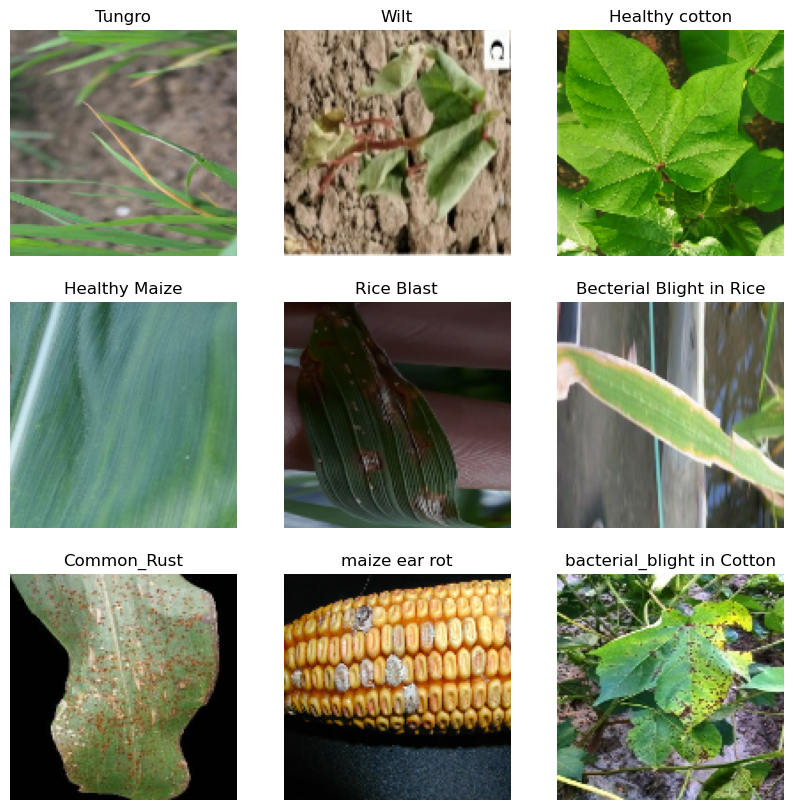

In [44]:
plt.figure(figsize=(10,10))
# The 'dataset.take(1)' will still fetch a batch of data, likely more than 9,
# but the loop will only iterate 9 times.
for image_batch, label_batch in dataset.take(1):
    # Change loop from 'range(12)' to 'range(9)' for 3x3
    for i in range(9):
        # Change subplot layout from (3,4,i+1) to (3,3,i+1)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, valid_split=0.1,
                          shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(valid_size)
    valid_ds = ds.skip(train_size).skip(valid_size)
    return train_ds, test_ds, valid_ds


In [8]:
train_ds, test_ds, valid_ds = dataset_partitions_tf(dataset)
print(f"Train: {len(train_ds)}, Test: {len(test_ds)}, Validation: {len(valid_ds)}")

Train: 380, Test: 47, Validation: 49


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0 / 255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [12]:
n_classes = len(class_names)

In [13]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [14]:
model.build(input_shape=(None, image_size, image_size, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,158,889 (8.24 MB)

 Trainable params: 2,158,889 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

In [17]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_ds,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 193s 396ms/step - accuracy: 0.4550 - loss: 2.0741 - val_accuracy: 0.5925 - val_loss: 1.4833 - learning_rate: 0.0010
Epoch 2/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 145s 381ms/step - accuracy: 0.6323 - loss: 1.3598 - val_accuracy: 0.6671 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 3/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 137s 361ms/step - accuracy: 0.7058 - loss: 1.0838 - val_accuracy: 0.7098 - val_loss: 1.0648 - learning_rate: 0.0010
Epoch 4/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 147s 387ms/step - accuracy: 0.7487 - loss: 0.9143 - val_accuracy: 0.7774 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 5/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 136s 358ms/step - accuracy: 0.7790 - loss: 0.7933 - val_accuracy: 0.7793 - val_loss: 0.8263 - learning_rate: 0.0010
Epoch 6/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 141s 372ms/step - accuracy: 0.8012 - loss: 0.7195 - val_accuracy: 0.8221 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 7/120
380/380 ━━━━━━━━━━━━━━━━━━━━ 145s 382ms/step -

In [18]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.9515 - loss: 0.1807
Test Loss: 0.1807
Test Accuracy: 95.15%


In [19]:
model_version = 1
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{model_version}.keras")

model.save(model_path)
print(f"✅ Model saved at: {os.path.abspath(model_path)}")

✅ Model saved at: c:\Users\vipul\plant doctor\saved_models\1.keras


In [20]:
# Get predictions and true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step


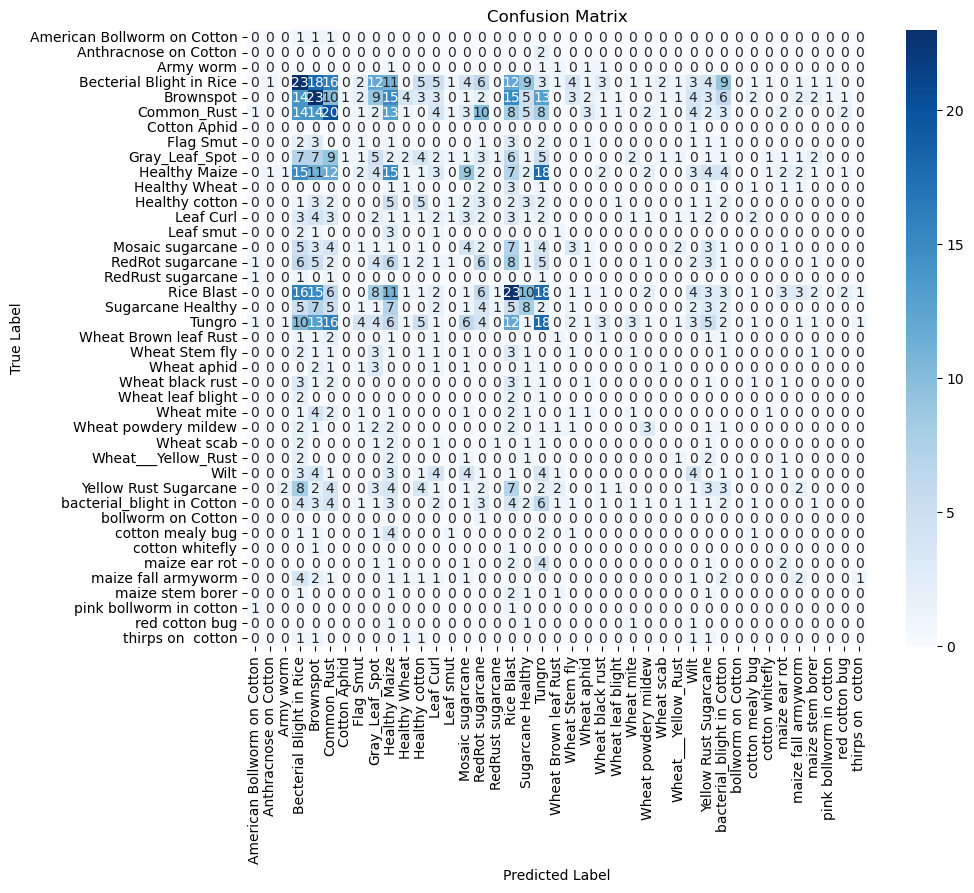

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

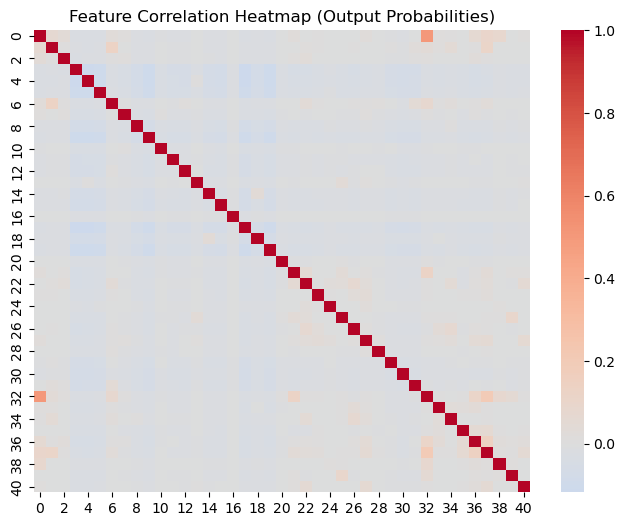

In [23]:
#Correlation Heatmap (Output Probabilities)

plt.figure(figsize=(8, 6))
sns.heatmap(np.corrcoef(y_pred_probs, rowvar=False), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Output Probabilities)")
plt.show()

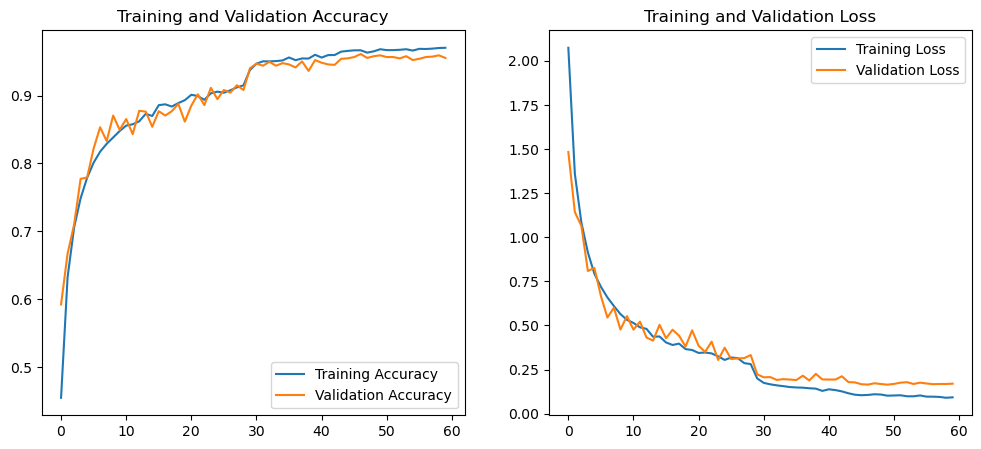

In [24]:
#Training and Validation Performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


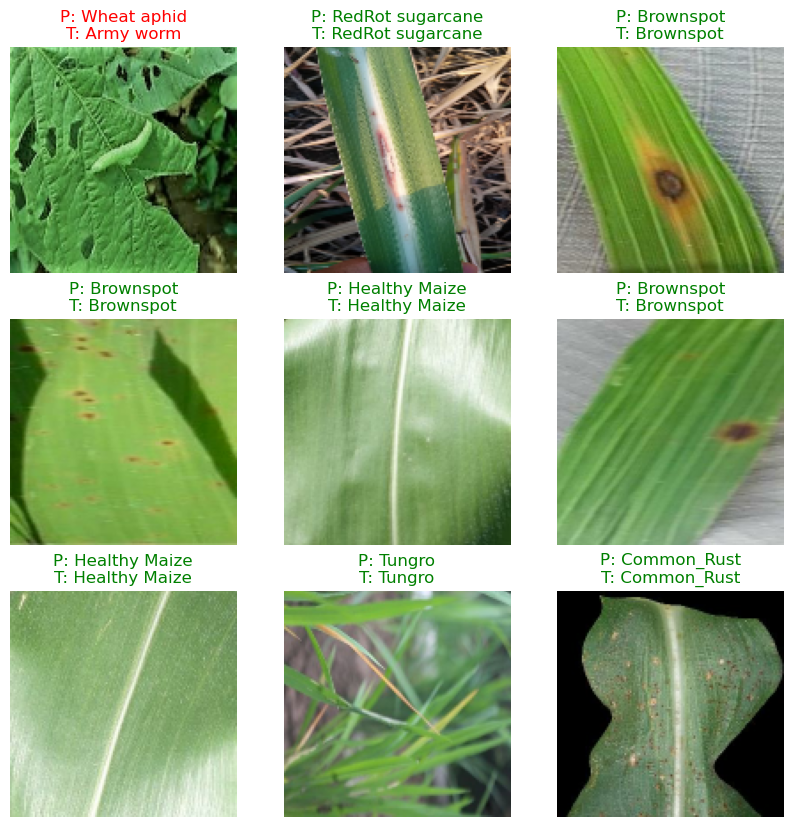

In [25]:
#Sample Predictions Visualization

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(preds[i])]
        true_label = class_names[labels[i]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
        plt.axis("off")
plt.show()

In [26]:
# %%
import pandas as pd
from datetime import datetime

# Create reports folder
report_dir = "./reports"
os.makedirs(report_dir, exist_ok=True)

# Save metrics as CSV
history_df = pd.DataFrame(history.history)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(report_dir, f"training_history_{timestamp}.csv")
history_df.to_csv(csv_path, index=False)

# Save accuracy/loss plots as PNG
plot_path = os.path.join(report_dir, f"training_plot_{timestamp}.png")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.savefig(plot_path)
plt.close()

print(f"📊 Training metrics saved to {csv_path}")
print(f"🖼️ Plot saved to {plot_path}")


📊 Training metrics saved to ./reports\training_history_20251023_212304.csv
🖼️ Plot saved to ./reports\training_plot_20251023_212304.png


In [27]:
# %%
lrs = model.optimizer.learning_rate.numpy()
print(f"Current Learning Rate: {lrs}")


Current Learning Rate: 1.6000001323845936e-06
